In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from nltk.metrics.agreement import AnnotationTask
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import accuracy_score as accuracy

In [2]:
pilot_file = "results_pilot_april_20.csv"
data = pd.read_csv(pilot_file)
data.columns = [c.replace('.', '_') for c in data.columns]

In [3]:
def extract_dataframe(data):
    '''
    Input: Pandas csv dataframe obtained from MTurk
    
    Output: Pandas dataframe levelled by (User x Sentenced_ID)
    '''
    data["dicts"] = data["Input_var_arrays"].map(lambda x: json.loads(x))
    global_list = []
    
    for row in data.itertuples():
        for idx, local_dict in enumerate(row.dicts):
            temp_dict = local_dict.copy()
            var_part = "Answer_noun_particularity" + str(idx + 1)
            var_part_c = "Answer_noun_part_certainty" + str(idx + 1)
            var_kind = "Answer_noun_class" + str(idx + 1)
            var_kind_c = "Answer_noun_class_certainty" + str(idx + 1)
            var_abs = "Answer_noun_abs" + str(idx + 1)
            var_abs_c = "Answer_noun_abs_certainty" + str(idx + 1)
            temp_dict['part'] = getattr(row, var_part)
            temp_dict['part_conf'] = getattr(row, var_part_c)
            temp_dict['kind'] = getattr(row, var_kind)
            temp_dict['kind_conf'] = getattr(row, var_kind_c)
            temp_dict['abs'] = getattr(row, var_abs)
            temp_dict['abs_conf'] = getattr(row, var_abs_c)
            temp_dict['worker_id'] = row.WorkerId
            global_list.append(temp_dict)
    
    return pd.DataFrame(global_list)

In [8]:
pilot_data = extract_dataframe(data)
# Rearrange the columns
cols = ['worker_id', 'sent_id', 'raw_sentence','predicate','noun','part','part_conf',
        'kind','kind_conf','abs','abs_conf']
pilot_data = pilot_data[cols]
pilot_data.head()

,worker_id,sent_id,raw_sentence,predicate,noun,part,part_conf,kind,kind_conf,abs,abs_conf
0,A2M6GFFEYJ5XP,en-ud-train.conllu sent_8206,Where in the world is Iguazu ?,Where,world,True,4,False,4,False,4
1,A2M6GFFEYJ5XP,en-ud-train.conllu sent_8206,Where in the world is Iguazu ?,Where,Iguazu,True,4,False,4,False,4
2,A2M6GFFEYJ5XP,en-ud-train.conllu sent_5978,"Yet , there is warmth and a familiarity with t...",is,warmth,False,4,False,4,True,4
3,A2M6GFFEYJ5XP,en-ud-train.conllu sent_6541,For those who believe ....................,believe,who,False,4,True,4,False,4
4,A2M6GFFEYJ5XP,en-ud-train.conllu sent_7297,Walk 2 blocks then turn right again .,Walk,blocks,True,2,False,2,False,4


### Response distribution

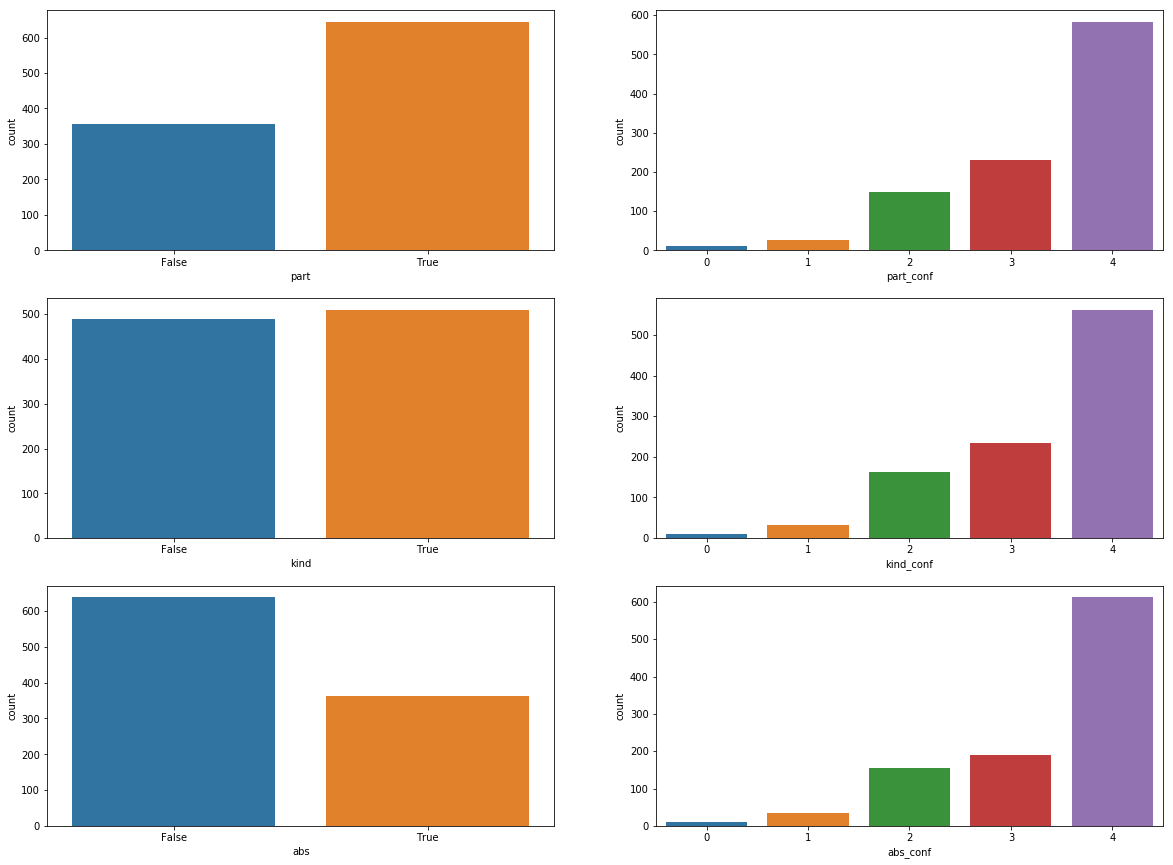

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 10))
sns.countplot(x='part', data=pilot_data, ax=axs[0][0])
sns.countplot(x='part_conf', data=pilot_data, ax=axs[0][1])
sns.countplot(x='kind', data=pilot_data, ax=axs[1][0])
sns.countplot(x='kind_conf', data=pilot_data, ax=axs[1][1])
sns.countplot(x='abs', data=pilot_data, ax=axs[2][0])
sns.countplot(x='abs_conf', data=pilot_data, ax=axs[2][1])

plt.show()

## Inter Annotator agreement